In [1]:
import pandas as pd

In [4]:
df = pd.read_csv("nyc_energy_consumption.csv")

In [5]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [6]:
df['timeStamp']=pd.to_datetime(df['timeStamp'])

In [7]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [8]:
import matplotlib.pyplot as plt

<AxesSubplot: xlabel='timeStamp'>

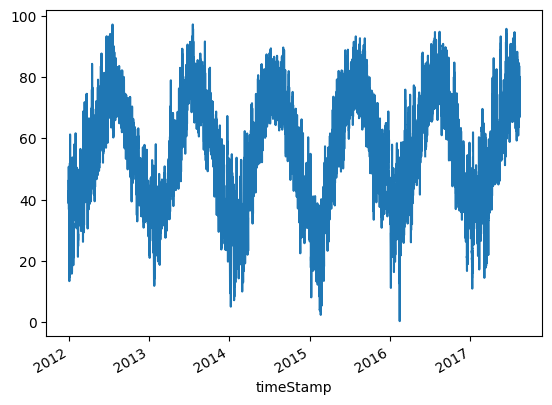

In [13]:
el_df = df.set_index('timeStamp')
el_df["temp"].plot()

In [14]:
df["demand"] = df["demand"].fillna(method="ffill")
df["temp"]=df["temp"].fillna(method='ffill')
df["temp"]=df["precip"].fillna(method='ffill')

In [15]:
el_df.resample('M').mean()

,demand,precip,temp
timeStamp,,,
2012-01-31,5757.495833,0.003116,37.174288
2012-02-29,5622.331609,0.001650,40.448046
2012-03-31,5479.845491,0.001179,49.607917
2012-04-30,5368.945833,0.003959,54.255903
2012-05-31,5867.896102,0.005064,64.188078
...,...,...,...
2017-04-30,5232.217107,0.002942,55.621764
2017-05-31,5421.315935,0.004031,61.115457
2017-06-30,6597.990346,0.003008,71.962625


In [17]:
final_df = el_df.resample('M').mean()

In [7]:
!pip install pmdarima

In [19]:
import pmdarima as pm

In [32]:
X = final_df.loc[:, final_df.columns!="demand"].to_numpy()

In [34]:
X.shape

(68, 2)

In [36]:
model = pm.auto_arima(
    final_df['demand'],
    X=X,
    m=12,
    seasonal=True,
    start_p=0, start_q=0, max_order=4,
    test='adf', error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=1087.789, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=1096.534, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1099.664, Time=0.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1097.711, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1157.641, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=1095.665, Time=0.17 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=1091.252, Time=0.16 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=1089.225, Time=0.43 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=1095.187, Time=0.35 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1099.090, Time=0.34 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1088.296, Time=0.18 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=1087.707, Time=0.16 sec
 ARIMA(0,0,1)(1,0,0)[12] inte

In [21]:
train=final_df[(final_df.index.get_level_values(0) >= '2012-01-31') & (final_df.index.get_level_values(0) <= '2017-04-30')]

In [22]:
test=final_df[(final_df.index.get_level_values(0) > '2017-04-30')]

In [23]:
test

,demand,precip,temp
timeStamp,,,
2017-05-31,5421.315935,0.004031,61.115457
2017-06-30,6597.990346,0.003008,71.962625
2017-07-31,7309.246677,0.002272,76.395270
2017-08-31,6971.501248,0.008961,73.730258


In [24]:
model.fit(train['demand'])

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(0, 0, 2, 12),
      suppress_warnings=True)

In [25]:
forecast=model.predict(n_periods=4, return_conf_int=True)

In [26]:
forecast

(2017-05-31    5322.118125
 2017-06-30    6205.604217
 2017-07-31    7187.965210
 2017-08-31    7302.376985
 Freq: M, dtype: float64,
 array([[4724.96265911, 5919.27359131],
        [5401.98228687, 7009.22614798],
        [6361.51377323, 8014.41664679],
        [6471.18869791, 8133.56527215]]))

In [27]:
forecast_df = pd.DataFrame(forecast[0], index=test.index, columns=['Prediction'])

<AxesSubplot: xlabel='timeStamp'>

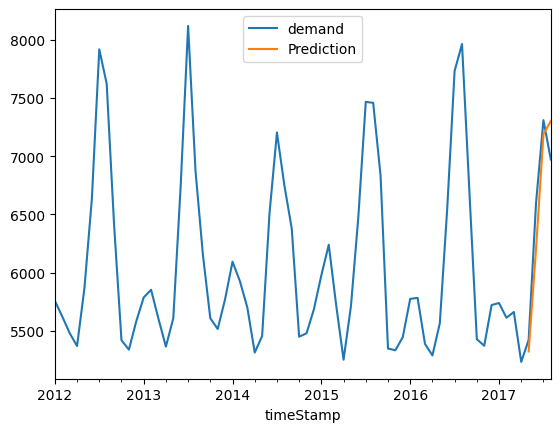

In [30]:
pd.concat([final_df['demand'],forecast_df],axis=1).plot()

### Does arima work for me?

In [5]:
from typing import Tuple, List

In [6]:
market_data_files = [ "market2_traders.csv", "market1_no_traders.csv", "round0_traders.csv" ]
save_for_later_file = [ "market3_traders.csv" ]

# loads, cleans the market data files

RESCALE = True
TRAINING_SIZE_PERCENTAGE = 0.8

def load_market_data() -> Tuple[List[TimeSeries], List[TimeSeries]]:
    all_p = []
    all_cov = []
    
    for market_file_name in market_data_files:
        # we make sure that we're only reading rows where the last traded prices aren't 0
        df = pd.read_csv(market_file_name).iloc[30:]
        for column in df.columns:
            assert df[column].isnull().values.any() == False
        assert len(df[df["LastTradedPriceETF"] == 0]) == 0
        assert len(df[df["LastTradedPriceFUT"] == 0]) == 0
        all_p.append(TimeSeries.from_series(df["MidPriceETF"]))
        all_cov.append(TimeSeries.from_series(df.loc[:,df.columns!="MidPriceETF"]))
        
    # split train/test
    p_train = [s[:math.floor(TRAINING_SIZE_PERCENTAGE * len(s))] for s in all_p]
    p_test = [s[math.floor(TRAINING_SIZE_PERCENTAGE * len(s)):] for s in all_p]
    cov_train = [s[:math.floor(TRAINING_SIZE_PERCENTAGE * len(s))] for s in all_cov]
    cov_test = [s[math.floor(TRAINING_SIZE_PERCENTAGE * len(s)):] for s in all_cov]

    # scaling
    if RESCALE:
        scaler_price = Scaler()
        p_train: List[TimeSeries] = scaler_price.fit_transform(p_train)
        p_test: List[TimeSeries] = scaler_price.transform(p_test)

        scaler_covariates=Scaler()
        cov_train: List[TimeSeries] = scaler_covariates.fit_transform(cov_train)
        cov_test: List[TimeSeries] = scaler_covariates.transform(cov_test)

    return p_train, p_test, cov_train, cov_test

NameError: name 'TimeSeries' is not defined